In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import pymysql
from sklearn.model_selection import train_test_split
import sequitur
from sequitur import models
import datetime

In [46]:
def load_data(filetype='sql'):
    if filetype == 'sql':
        dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
        data = pd.read_sql("SELECT * FROM SUMMARY", dbcon)
    elif filetype == 'csv':
        data = pd.read_csv('summary.csv')
    data.replace([1.1e+308], np.nan, inplace=True)
    data.fillna(np.nan, inplace=True)
    data.dropna(axis=1,how='all',inplace=True)
    #data = (data - data.mean())/data.std()
    data = data.replace([np.nan], 0)
    return data

def OrdinalToDatetime(ordinal):
    try:
        plaindate = datetime.date.fromordinal(int(ordinal))
    except:
        plaindate = datetime.date.fromordinal(1)
    date_time = datetime.datetime.combine(plaindate, datetime.datetime.min.time())
    return date_time + datetime.timedelta(days=ordinal-int(ordinal))

def transform_timestamp(stamp):
        try:
            return OrdinalToDatetime(stamp/(24*3600*1000)).strftime('%d-%m-%Y %H:%M:%S.%f')
        except:
            return stamp

def convert_timestamp(data):
    timestamps = data[data.columns[0]].values
    data[data.columns[0]] = [transform_timestamp(time) for time in timestamps]
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
    return data

In [48]:
data = load_data('csv')
#data = data[25000:35000]

In [49]:
data[data.columns[0]]

0        63428486400000
1        63428488200000
2        63428490000000
3        63428491800000
4        63428493600000
              ...      
65403    63564134400000
65404    63564136200000
65405    63564138000000
65406    63564139800000
65407    63564141600000
Name: timestamp, Length: 65408, dtype: int64

In [50]:
data = convert_timestamp(data)

In [52]:
data

,timestamp,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,2010-12-20 00:00:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-12-20 00:30:00.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-20 00:59:59.999997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-12-20 01:30:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-12-20 02:00:00.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,2015-08-04 00:00:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65404,2015-08-04 00:30:00.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65405,2015-08-04 00:59:59.999997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65406,2015-08-04 01:30:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
xl = pd.read_excel('quasi_static.xlsx')

In [15]:
xl

,Timestamp,TZ,Thermocouple_1 (degC),Thermocouple_3 (degC),Thermocouple_5 (degC),Thermocouple_7 (degC),Thermocouple_9 (degC),Thermocouple_11 (degC),Thermocouple_13 (degC),Thermocouple_15 (degC),...,Strain_7 (ppm),Strain_8 (ppm),Strain_9 (ppm),Strain_10 (ppm),Displacement_1 (ppm),Displacement_2 (ppm),Displacement_3 (ppm),Displacement_4 (ppm),Tilt (mV),Tilt_temp (Ohms)
0,2013-10-03 12:31:00.053,n,19.133708,19.163682,19.060860,19.077936,19.116634,19.077936,19.022160,19.073572,...,-53.492760,73.491568,8.071987,-130.12016,1172.5450,2102.4760,1074.7284,2453.8154,-30.304062,351.66616
1,2013-10-03 12:32:00.006,n,19.193284,19.219082,19.111904,19.150414,19.176212,19.137514,19.086294,19.120442,...,-52.525112,75.141008,9.313710,-129.69698,1173.1368,2103.2070,1075.2552,2454.0500,-30.374382,351.79496
2,2013-10-03 12:33:00.008,n,19.176602,19.202212,19.107932,19.150802,19.086492,19.146632,19.043428,19.133542,...,-53.074668,74.864784,9.173710,-129.26968,1173.2646,2103.1098,1075.8784,2454.8364,-30.718834,351.73568
3,2013-10-03 12:34:00.010,n,19.174510,19.225918,19.093128,19.153074,19.144538,19.157438,19.067330,19.131640,...,-52.943080,74.733424,9.858492,-130.09756,1172.9394,2102.5640,1075.3572,2454.5136,-30.097770,351.73960
4,2013-10-03 12:35:00.012,n,19.097790,19.162100,19.029116,19.093428,19.016214,19.106328,18.973528,19.059278,...,-54.738448,72.558232,7.120934,-131.63498,1171.9746,2102.3582,1074.0392,2453.7542,-30.473992,351.67420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138229,2014-01-07 12:20:00.001,n,17.650678,17.569200,17.736706,17.491708,17.891468,17.629218,18.033300,17.706700,...,-51.248072,84.136608,12.586020,-124.95146,1159.9632,2106.0826,1170.7118,2501.6330,-31.102722,351.79408
138230,2014-01-07 12:21:00.003,n,17.656972,17.579676,17.747368,17.493638,17.910676,17.648426,18.013774,17.725910,...,-51.520572,84.138704,12.857348,-125.36566,1159.9172,2105.8218,1170.4092,2501.8908,-31.139992,351.73588
138231,2014-01-07 12:22:00.006,n,17.653686,17.589304,17.756994,17.490348,17.903020,17.623678,18.006312,17.731168,...,-51.379980,84.540320,12.724238,-125.23264,1159.3780,2106.0616,1170.5784,2501.7038,-30.797730,351.70660
138232,2014-01-07 12:23:00.007,n,17.659106,17.590354,17.740956,17.469936,17.899894,17.616182,17.990084,17.710760,...,-49.740244,86.048456,13.680220,-123.99316,1160.4216,2107.5850,1171.6508,2502.9332,-31.723770,351.74304


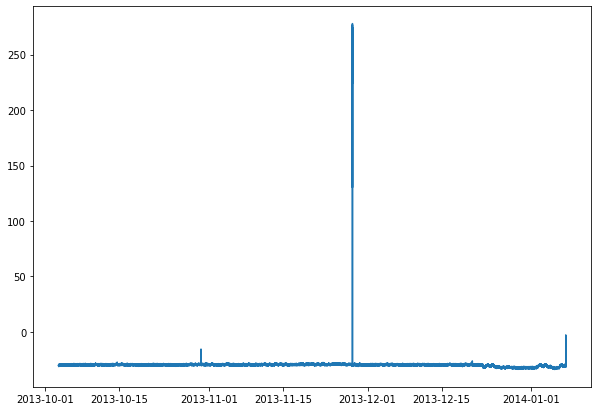

In [53]:
plt.figure(figsize=(10,7))
plt.plot(xl['Timestamp'], xl['Tilt (mV)'])

In [54]:
data

,timestamp,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,2010-12-20 00:00:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-12-20 00:30:00.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-20 00:59:59.999997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-12-20 01:30:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-12-20 02:00:00.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,2015-08-04 00:00:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65404,2015-08-04 00:30:00.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65405,2015-08-04 00:59:59.999997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65406,2015-08-04 01:30:00.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
def create_training_data(data):
    training_data = data.drop(data.columns[0], axis=1)
    training_data.dropna(axis=0, how='all', inplace=True)
    training_data.reset_index(drop=True)
    training_data = (training_data - training_data.mean())/training_data.std()
    return training_data

In [5]:
training_data = data.drop('timestamp', axis=1)
training_data.dropna(axis=0, how='all', inplace=True)
training_data.reset_index(drop=True)

,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,NOAA_WIS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
training_data = (training_data - training_data.mean())/training_data.std()

In [55]:
training_data

,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,NOAA_WIS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
1,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
2,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
3,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
4,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.761748,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
65404,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.761748,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
65405,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.761748,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
65406,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.330816,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614


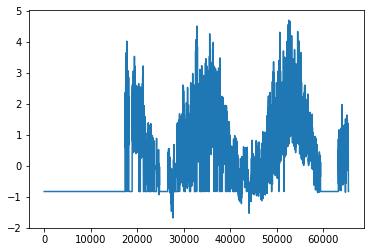

In [56]:
plt.plot(training_data['TSH000ED'])

In [25]:
training_data = create_training_data(data)

In [27]:
training_data

,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,NOAA_WIS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
1,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
2,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
3,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
4,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.761748,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
65404,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.761748,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
65405,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.761748,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
65406,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,0.330816,...,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614


In [57]:
torch.from_numpy(training_data.values)

tensor([[-0.8325, -0.8321, -0.8749,  ..., -0.5321, -0.5370, -0.5666],
        [-0.8325, -0.8321, -0.8749,  ..., -0.5321, -0.5370, -0.5666],
        [-0.8325, -0.8321, -0.8749,  ..., -0.5321, -0.5370, -0.5666],
        ...,
        [-0.8325, -0.8321, -0.8749,  ..., -0.5321, -0.5370, -0.5666],
        [-0.8325, -0.8321, -0.8749,  ..., -0.5321, -0.5370, -0.5666],
        [-0.8325, -0.8321, -0.8749,  ..., -0.5321, -0.5370, -0.5666]],
       dtype=torch.float64)

In [58]:
num_epochs=10
batch_size=100
learning_rate=1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [65]:
tensor_data = torch.tensor(training_data.values.astype(np.float32))
load = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [70]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [68]:
train_set = [torch.randn(10,5,5) for _ in range(100)]

In [71]:
dataset, seq_len, n_features = create_dataset(training_data)

In [84]:
l = [training_data.iloc[i].values for i in range(len(training_data))]

In [85]:
l

[array([-0.8325312 , -0.83210765, -0.87494462, -0.90686808, -0.92882483,
        -0.96353043, -0.88505451, -0.70686266, -0.68968857, -1.39291145,
        -1.5445121 , -1.4709681 , -0.65975805, -0.67902486, -0.11187925,
        -0.19247841, -0.20764787, -0.15554366, -0.18927028, -0.18950919,
         0.11842702, -0.04477434, -0.16609476, -0.41217008, -0.42866207,
        -0.23042679, -0.27788472,  0.15081667, -0.16560326, -0.17957775,
        -0.18705503, -0.04963726, -0.18029764, -0.20072043, -0.04362496,
        -0.16817658, -0.14543696, -0.18314136, -0.09852373, -0.03118152,
        -0.06356491, -0.09746784, -0.02371347, -0.01503323, -0.21502044,
        -0.22473156, -0.22040915, -0.26235789,  0.06604967,  0.51599001,
        -0.75150322, -0.48452516, -0.79510788, -0.2105358 , -0.21299295,
        -0.21467998, -0.41193249, -0.73709273, -0.64342434, -0.59886348,
        -0.68435248, -0.49883505, -0.67101582, -0.64962725, -0.52892106,
        -0.45292513, -0.79658547, -0.76326186, -0.6

In [179]:
encoder, decoder, encodings, losses = sequitur.quick_train(models.LINEAR_AE, dataset, 10, True, 0.001, 20)

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Loss: 5.924330387839265
Epoch: 2, Loss: 4.039291155607129
Epoch: 3, Loss: 3.3455632566316127
Epoch: 4, Loss: 2.8916152400838695
Epoch: 5, Loss: 2.554291298871708
Epoch: 6, Loss: 2.2777934919448506
Epoch: 7, Loss: 2.06064577586732
Epoch: 8, Loss: 1.8864660609071462
Epoch: 9, Loss: 1.7479067319663624
Epoch: 10, Loss: 1.6382036999620633
Epoch: 11, Loss: 1.5446750231217632
Epoch: 12, Loss: 1.4642489709180158
Epoch: 13, Loss: 1.3955170776206223
Epoch: 14, Loss: 1.3415732983820043
Epoch: 15, Loss: 1.2907982224475976
Epoch: 16, Loss: 1.2375251298304828
Epoch: 17, Loss: 1.1888591513902798
Epoch: 18, Loss: 1.142636761914823
Epoch: 19, Loss: 1.0988572754184136
Epoch: 20, Loss: 1.0767173896332192


In [48]:
for idx, item in enumerate(load):
    print(idx, item.view(-1,len(item)))
    break

0 tensor([[1.2511, 1.1271, 1.8600, 1.2282, 1.5207, 1.2647, 1.1400, 1.2847, 1.0171,
         1.4057, 1.3552, 1.1208, 1.1660, 1.1384, 1.1471, 0.9407, 0.9383, 1.0409,
         1.4231, 0.9323, 1.1629, 1.0826, 1.0511, 0.9068, 0.9876, 1.3208, 1.0522,
         0.8705, 0.6813, 0.8923, 0.9470, 1.1603, 0.9544, 0.9846, 0.9245, 1.2407,
         1.1755, 1.1780, 1.0732, 1.0021, 0.8782, 0.8179, 0.3731, 0.5246, 0.3795,
         0.4737, 0.8632, 0.7981, 0.6389, 0.7082, 0.9093, 0.6802, 1.0034, 0.9509,
         1.0199, 0.9199, 0.8684, 0.9347, 1.0726, 0.9452, 1.0120, 1.0657, 1.0017,
         0.9384, 1.0099, 1.0713, 1.1380, 0.9822, 0.8211, 0.9539, 0.8267, 0.9783,
         0.8633, 0.7762, 0.5450, 0.8740, 0.4254, 0.3957, 0.4366, 0.5874, 0.3538,
         0.2721, 0.4339, 0.2089, 0.4943, 0.8820, 0.3481, 0.4344, 0.3692, 0.6360,
         0.6712, 0.7660, 1.1150, 1.3249, 1.7295, 2.1041, 2.0530, 2.1517, 2.7353,
         2.4007]])


In [10]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 100)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [154]:
model = AutoEncoder()
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []

for epoch in range(num_epochs):
    #item = item.to(device)
    for idx, item in enumerate(load):
        # forward
        item = item.view(len(item), -1)
        output = model(item)
        loss = loss_func(output, item)
        
        # backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_list.append(loss)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 128x62)